# BayesOPT Example for showing Gittins >> EIpu
Extension of the numerical examples presented in Theorem 1 of Raul and Peter's paper which aimed to show the limitation of EIpu and EI. This experiment extends the scope from Pandora's box (discrete finite points) to Bayesian optimization (continuous domain) and compares Gittins with EIpu/EI.

In [1]:
import torch
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

## Define the amplitude function and the cost function 
The continuous amplitude function and the continuous cost function are constructed based on the variances and costs of the discrete finite points provided in the original example

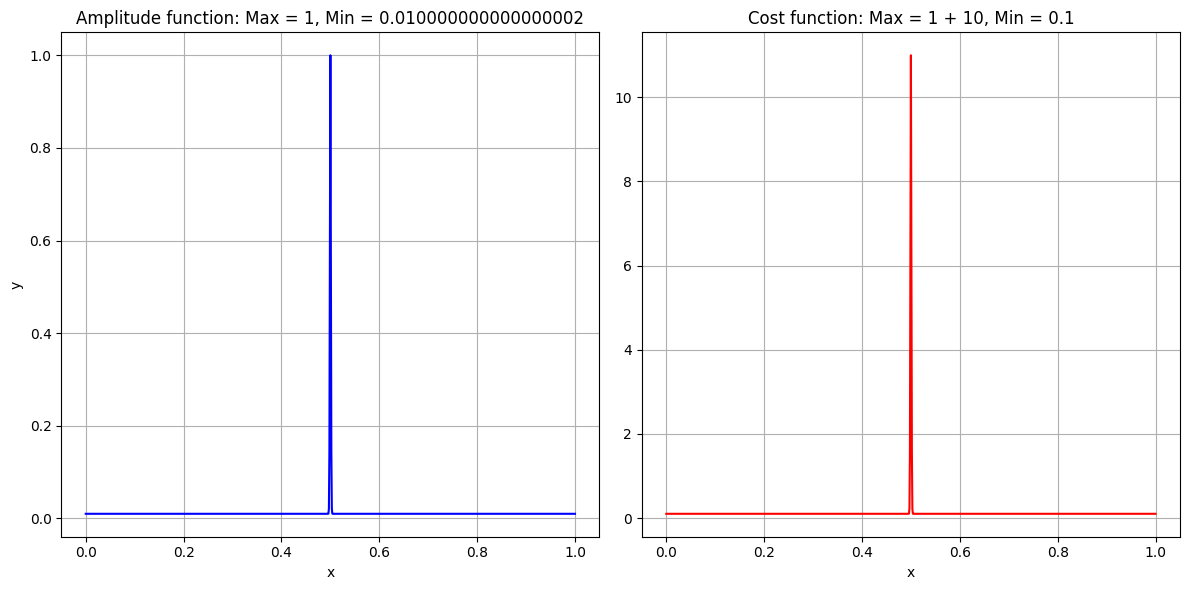

In [2]:
import matplotlib.pyplot as plt
# Define typical small values for epsilon and delta, and a moderate value for K
epsilon = 0.1
delta = 10
amplitude_function_width = 0.001
cost_function_width = 0.001

# Define the functions for the amplitude and the cost
def amplitude_function(x):
    width = amplitude_function_width  # Width of the bump to cover only the central point
    amplitude = torch.exp(-((x - 0.5)**2) / (2 * width**2)) * (1 - epsilon**2) + epsilon**2
    return amplitude.squeeze(-1)

def cost_function(x):
    width = cost_function_width  # Width of the bump to cover only the central point
    peak_height = 1 + delta - epsilon
    cost = torch.exp(-((x - 0.5)**2) / (2 * width**2)) * peak_height + epsilon
    return cost.squeeze(-1)

# Generate x values from 0 to 1
x_values = torch.linspace(0, 1, 1001, dtype=torch.float64, device=device)

# Generate y values for amplitude function and cost function
y_values_amplitude = [amplitude_function(x) for x in x_values]
y_values_cost = [cost_function(x) for x in x_values]

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for amplitude function
plt.subplot(1, 2, 1)
plt.plot(x_values, y_values_amplitude, label="Amplitude function", color='blue')
plt.title(f"Amplitude function: Max = 1, Min = {epsilon**2}")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for cost function
plt.subplot(1, 2, 2)
plt.plot(x_values, y_values_cost, label="Cost function", color='red')
plt.title(f"Cost function: Max = 1 + {delta}, Min = {epsilon}")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

### TODO
Adjust the hyperparamters to get a larger discrepancy between EIpu and Gittins

### Question
Is it necessary to pass epsilon = 0.1, delta = 0.05, K = 100 as parameters to amplitude_function and cost_function?

## Define the objective function
The objective functions are constructed as sample paths drawn from the Matern kernel multiplied by the amplitude function

In [3]:
from pandora_bayesopt.utils import create_objective_function
# Create the objective model
dim = 1
nu = 2.5
lengthscale = 0.01
outputscale = 1.0
num_rff_features = 1280
seed = 0
torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

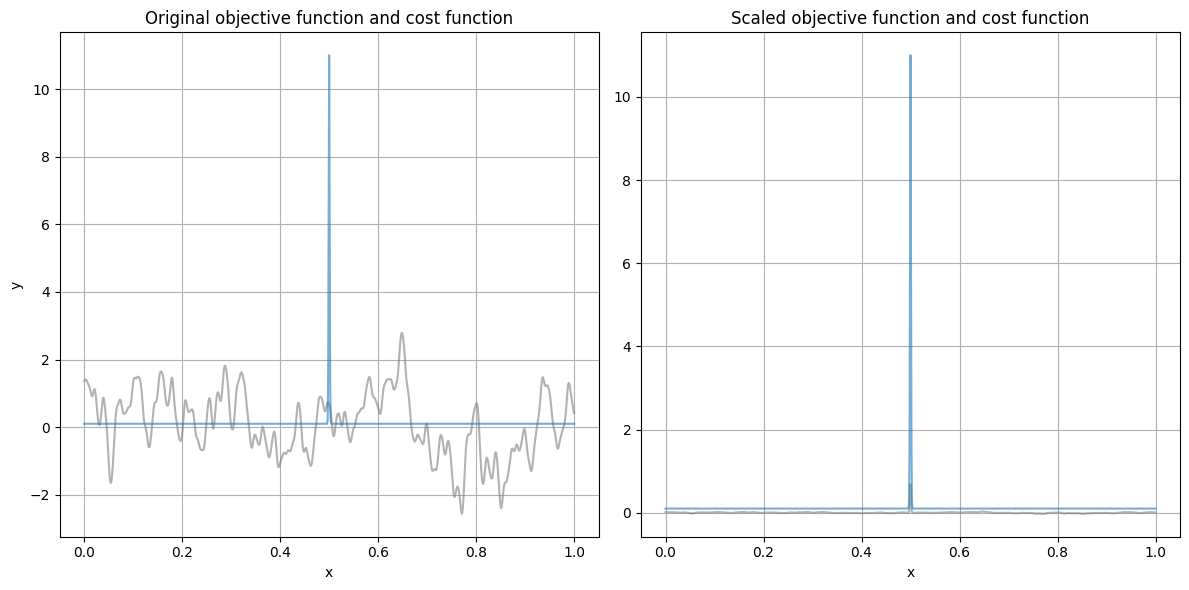

In [4]:
test_x = torch.linspace(0, 1, 1001, dtype=torch.float64, device=device)

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for original objective function
plt.subplot(1, 2, 1)
plt.plot(test_x.cpu().numpy(), matern_sample(test_x.view(-1,1)).numpy(), color='tab:grey', label="Original objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).numpy(), label="Cost function", alpha=0.6)
plt.title(f"Original objective function and cost function")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for scaled objective function
plt.subplot(1, 2, 2)
plt.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), color='tab:grey', label="Scaled objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).numpy(), label="Cost function", alpha=0.6)
plt.title(f"Scaled objective function and cost function")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
def plot_posterior(ax,objective_function,model,test_x,train_x,train_y):
    
    with torch.no_grad():
        
        # Plot the objective function at the test points
        ax.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), 'tab:grey', alpha=0.6)
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x.unsqueeze(1).unsqueeze(1))

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze(-1).squeeze(-1)
        upper = upper.squeeze(-1).squeeze(-1)
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8)
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean.squeeze(-1).squeeze(-1).cpu().numpy(), alpha=0.8)
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.2)
        
    
    ax.legend(['Objective Function', 'Observed Data', 'Mean', 'Confidence'])

### Define a customized kernel as Matern kernel with input-dependent amplitude (outputscale)

In [6]:
from gpytorch.kernels import MaternKernel
from pandora_bayesopt.kernel import VariableAmplitudeKernel

### Note
This class VariableAmplitudeKernel can be found in pandora_bayesopt.kernel

## Fit a GP model with observation data and a specified kernel

In [7]:
from pandora_bayesopt.utils import fit_gp_model

### Note
This function can be found in pandora_bayesopt.utils

In [8]:
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
kernel = VariableAmplitudeKernel(base_kernel, amplitude_function)

### Question
Instead of setting the kernel inside fit_gp_model with given smoothness and lengthscale parameters, I set the kernel before running the BayesOPT loop so that I can also use fit_gp_model with a standard Matern kernel (base_kernel) for other tasks. However, it seems that if I only set it once, then it would be a different initial kernel when I run another policy. Not sure why this happens. To avoid such issues, I reset it before running every policy.

In [9]:
maximize = True
budget = 1+delta

In [10]:
from pandora_bayesopt.utils import find_global_optimum
global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)
print("global_optimum", global_optimum_point, global_optimum_value)
print()

global_optimum tensor([0.5000]) 0.685532617060132



## Test EI policy

initial x: tensor([[0.]])
initial y: tensor([0.0137])
best oberved value: 0.013677983402295115
Iteration 0, measuring at x=0.4999999999891902, y=0.6845484702663631


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0137]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


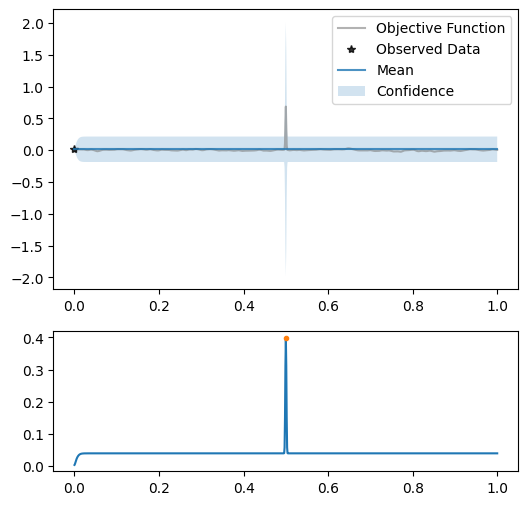

best oberved value: 0.6845484702663631
new cost: 10.999999999999998
cumulative cost: 10.999999999999998
Iteration 1, measuring at x=0.49960372035294764, y=0.6485925312745706


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3491]), std = tensor([0.4744])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


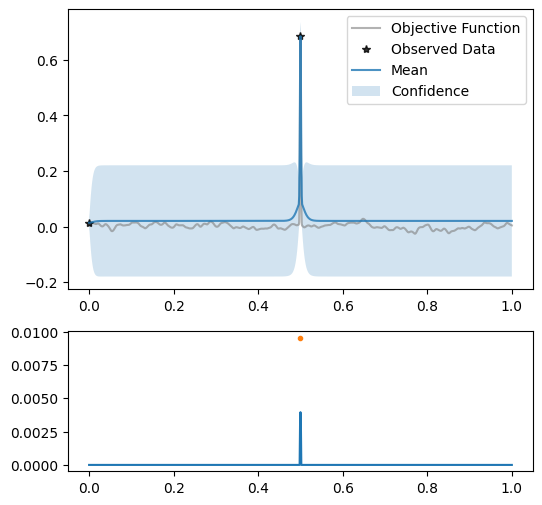

best oberved value: 0.6845484702663631
new cost: 10.176883214321789
cumulative cost: 21.176883214321787


In [11]:
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.kernels import MaternKernel

torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
print("initial x:", x)
print("initial y:", y)
best_f = y.max().item() if maximize else y.min().item()

EI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EI_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.stack([torch.zeros(dim), torch.ones(dim)]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )
    
    # Plot the posterior and the EI
    f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot the posterior
    plot_posterior(ax1,objective_function,model,test_x,x,y)
    
    # Plot EI
    acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'.')
    
    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    plt.show()
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EI_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### Question
- Do I need to care about these warnings?

## Test EI per unit cost policy

best oberved value: 0.013677983402295115


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0137]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


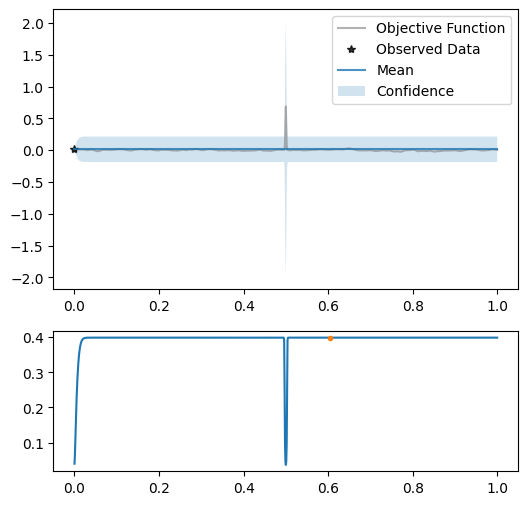

Iteration 0, measuring at x=0.6053624842315912, y=0.004350008248196293
best oberved value: 0.013677983402295115
new cost: 0.1
cumulative cost: 0.1


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0090]), std = tensor([0.0066])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


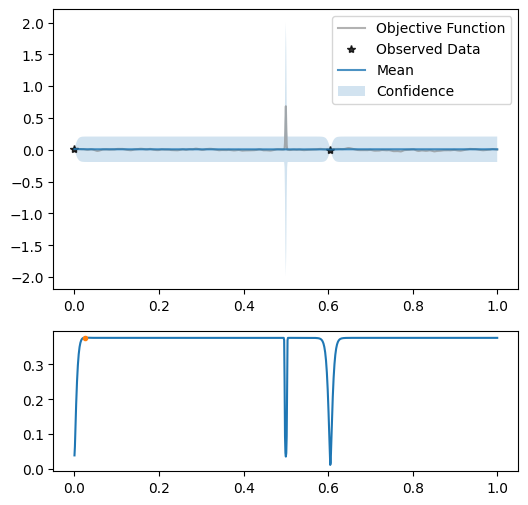

Iteration 1, measuring at x=0.02573509108558463, y=0.006051208367115396
best oberved value: 0.013677983402295115
new cost: 0.1
cumulative cost: 0.2


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0080]), std = tensor([0.0050])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


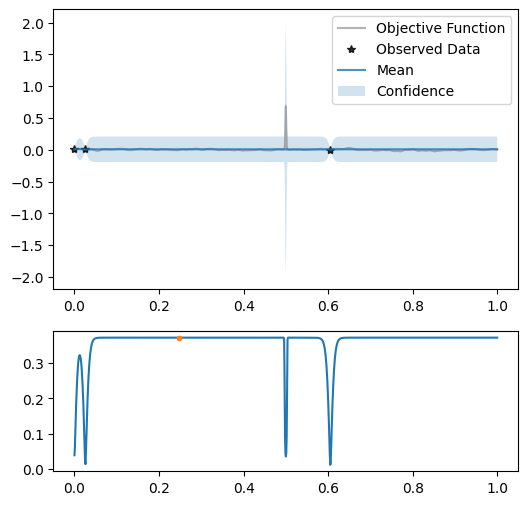

Iteration 2, measuring at x=0.2476162026429679, y=-0.002214676125756946
best oberved value: 0.013677983402295115
new cost: 0.1
cumulative cost: 0.30000000000000004


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0055]), std = tensor([0.0065])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 3, measuring at x=0.06730115361273747, y=0.006129971071260854
best oberved value: 0.013677983402295115
new cost: 0.1
cumulative cost: 0.4
Iteration 4, measuring at x=0.10492355505164672, y=0.014433669156840082
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 0.5


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0056]), std = tensor([0.0057])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0071]), std = tensor([0.0062])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 5, measuring at x=0.1278874326609337, y=-0.001960240458344298
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 0.6
Iteration 6, measuring at x=0.9868363449349999, y=0.011485918810969532
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 0.7
Iteration 7, measuring at x=0.9614183953200026, y=-0.0020155638082520458
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 0.7999999999999999
Iteration 8, measuring at x=0.42744098231653754, y=-0.004044358836137333
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 0.8999999999999999


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0058]), std = tensor([0.0066])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0065]), std = tensor([0.0065])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0055]), std = tensor([0.0067])). Please consider scaling t

Iteration 9, measuring at x=0.7773299776016783, y=-0.010714168173527314
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 0.9999999999999999
Iteration 10, measuring at x=0.08750678399451348, y=0.004968579981399027
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 1.0999999999999999


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0032]), std = tensor([0.0081])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0033]), std = tensor([0.0077])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 11, measuring at x=0.6387538436034876, y=0.013905092096171918
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 1.2
Iteration 12, measuring at x=0.6603225671716437, y=0.011328566776420121
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 1.3


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0042]), std = tensor([0.0079])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0047]), std = tensor([0.0079])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 13, measuring at x=0.6845325347433123, y=-0.0032008714978857085
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 1.4000000000000001
Iteration 14, measuring at x=0.5655350849576344, y=0.005521459152914851
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 1.5000000000000002
Iteration 15, measuring at x=0.5332147099344227, y=0.004086159652086228
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 1.6000000000000003


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0041]), std = tensor([0.0079])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0042]), std = tensor([0.0076])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0042]), std = tensor([0.0074])). Please consider scaling t

Iteration 16, measuring at x=0.871396064268829, y=-0.007289620816209543
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 1.7000000000000004
Iteration 17, measuring at x=0.4940378897734899, y=0.0057986403872942035
best oberved value: 0.014433669156840082
new cost: 0.10000020823129346
cumulative cost: 1.8000002082312938


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0036]), std = tensor([0.0076])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0037]), std = tensor([0.0074])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 18, measuring at x=0.3365809449843063, y=-0.00029541739975700817
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 1.900000208231294
Iteration 19, measuring at x=0.18805515853801466, y=0.002238433303922302
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 2.000000208231294


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0035]), std = tensor([0.0073])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0034]), std = tensor([0.0071])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 20, measuring at x=0.4666253323567628, y=-0.008268212679145162
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 2.100000208231294
Iteration 21, measuring at x=0.37991720598012374, y=-0.007875977609138395
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 2.200000208231294


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0029]), std = tensor([0.0074])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0024]), std = tensor([0.0075])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 22, measuring at x=0.29356544977768484, y=0.012162295077626879
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 2.3000002082312943
Iteration 23, measuring at x=0.2740270662988627, y=0.010127323982903565
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 2.4000002082312943


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0028]), std = tensor([0.0076])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0031]), std = tensor([0.0076])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 24, measuring at x=0.7289948867777746, y=-0.0024029247458902904
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 2.5000002082312944
Iteration 25, measuring at x=0.918137988387072, y=-0.006624674011198126
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 2.6000002082312945


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0029]), std = tensor([0.0075])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0026]), std = tensor([0.0076])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 26, measuring at x=0.82518770524855, y=-0.011043116039224319
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 2.7000002082312946
Iteration 27, measuring at x=0.31266719231614526, y=0.012450589700486165
best oberved value: 0.014433669156840082
new cost: 0.1
cumulative cost: 2.8000002082312947
Iteration 28, measuring at x=0.16015169132132864, y=0.015572166088820089
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 2.900000208231295


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0021]), std = tensor([0.0079])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0024]), std = tensor([0.0080])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0029]), std = tensor([0.0082])). Please consider scaling t

Iteration 29, measuring at x=0.2161639972700368, y=0.004729728171396828
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 3.000000208231295
Iteration 30, measuring at x=0.04659583384807165, y=-0.0012471523839630758
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 3.100000208231295
Iteration 31, measuring at x=0.5852513427434278, y=0.012881436092489767
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 3.200000208231295
Iteration 32, measuring at x=0.5133204325415406, y=0.0006736745396050948
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 3.300000208231295


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0029]), std = tensor([0.0081])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0028]), std = tensor([0.0080])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0031]), std = tensor([0.0081])). Please consider scaling t

Iteration 33, measuring at x=0.7519177796281176, y=-0.016130170808968333
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 3.4000002082312952
Iteration 34, measuring at x=0.6231542694230242, y=0.014114384000096673
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 3.5000002082312953
Iteration 35, measuring at x=0.4042666722672105, y=-0.008666060096082622
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 3.6000002082312954
Iteration 36, measuring at x=0.7071285039683582, y=-0.009858460176410453
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 3.7000002082312955


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0025]), std = tensor([0.0085])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0028]), std = tensor([0.0086])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0025]), std = tensor([0.0087])). Please consider scaling t

Iteration 37, measuring at x=0.8948609280121248, y=-0.0026123051126068415
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 3.8000002082312956
Iteration 38, measuring at x=0.35736055468678274, y=-0.005207273626102049
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 3.9000002082312957
Iteration 39, measuring at x=0.8011144432610395, y=0.007050067916857578
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 4.000000208231295
Iteration 40, measuring at x=0.9403129673462279, y=0.012411825773830874
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 4.100000208231295


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0021]), std = tensor([0.0087])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0019]), std = tensor([0.0087])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0020]), std = tensor([0.0086])). Please consider scaling t

Iteration 41, measuring at x=0.8488371063942061, y=-0.022076985128878665
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 4.200000208231295
Iteration 42, measuring at x=0.14581739133475188, y=0.00743417785643275
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 4.300000208231294
Iteration 43, measuring at x=1.0, y=0.00421515667012155
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 4.400000208231294


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0017]), std = tensor([0.0093])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0018]), std = tensor([0.0092])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0019]), std = tensor([0.0091])). Please consider scaling t

Iteration 44, measuring at x=0.5493996341953832, y=-0.0005493297368789425
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 4.5000002082312935
Iteration 45, measuring at x=0.44652078625706537, y=-0.0062438082755636995
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 4.600000208231293
Iteration 46, measuring at x=0.1731683075811884, y=0.007815265631041079
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 4.700000208231293
Iteration 47, measuring at x=0.23129024450109611, y=-0.003536786848851733
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 4.8000002082312925
Iteration 48, measuring at x=0.01232326621884873, y=0.01107799553492771
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 4.900000208231292


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0018]), std = tensor([0.0090])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0016]), std = tensor([0.0090])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0018]), std = tensor([0.0090])). Please consider scaling t

Iteration 49, measuring at x=0.202396569057076, y=0.0020243613618202427
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 5.000000208231292
Iteration 50, measuring at x=0.26157778616597893, y=0.001003349148563721
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 5.100000208231291
Iteration 51, measuring at x=0.974956671807172, y=-0.0016320231953213652
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 5.200000208231291
Iteration 52, measuring at x=0.4812129007065183, y=0.009027601592758719
best oberved value: 0.015572166088820089
new cost: 0.1
cumulative cost: 5.300000208231291
Iteration 53, measuring at x=0.6495145732969148, y=0.027606883891308952
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 5.40000020823129


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0019]), std = tensor([0.0088])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0018]), std = tensor([0.0087])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0018]), std = tensor([0.0087])). Please consider scaling t

Iteration 54, measuring at x=0.32399290128485225, y=0.01501806625541574
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 5.50000020823129
Iteration 55, measuring at x=0.1155337831323027, y=0.012872721668619
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 5.60000020823129
Iteration 56, measuring at x=0.6721672050547554, y=-0.003559286029683909
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 5.700000208231289
Iteration 57, measuring at x=0.8122712271043531, y=-0.015706541823694815
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 5.800000208231289
Iteration 58, measuring at x=0.7901458068048229, y=-0.0009670554401504579
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 5.900000208231289


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0026]), std = tensor([0.0093])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0028]), std = tensor([0.0093])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0027]), std = tensor([0.0093])). Please consider scaling t

Iteration 59, measuring at x=0.9301512167336873, y=0.006817849246338409
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 6.000000208231288
Iteration 60, measuring at x=0.2839349497684511, y=0.015057917414791542
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 6.100000208231288
Iteration 61, measuring at x=0.575755393278366, y=0.011228299292434147
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 6.2000002082312875
Iteration 62, measuring at x=0.9503457419100497, y=0.009733987141776153
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 6.300000208231287


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0024]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0026]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0027]), std = tensor([0.0094])). Please consider scaling t

Iteration 63, measuring at x=0.8833162485281417, y=-0.005172930339013944
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 6.400000208231287
Iteration 64, measuring at x=0.3920522619645653, y=-0.006000490390542925
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 6.500000208231286
Iteration 65, measuring at x=0.5950904362203572, y=0.007909832851483469
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 6.600000208231286
Iteration 66, measuring at x=0.07727749800710941, y=0.005836145560107006
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 6.700000208231286


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0027]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0026]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0027]), std = tensor([0.0093])). Please consider scaling t

Iteration 67, measuring at x=0.7647801352016889, y=-0.01886871013639043
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 6.800000208231285
Iteration 68, measuring at x=0.906224761580959, y=-0.008960260169206553
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 6.900000208231285
Iteration 69, measuring at x=0.30319177317624096, y=-0.000601804530005083
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 7.000000208231285
Iteration 70, measuring at x=0.4161595873241481, y=-0.006846378372201952
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 7.100000208231284
Iteration 71, measuring at x=0.03594250382253442, y=0.005590202576833074
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 7.200000208231284


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0024]), std = tensor([0.0095])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0022]), std = tensor([0.0096])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0022]), std = tensor([0.0095])). Please consider scaling t

Iteration 72, measuring at x=0.6956072873967457, y=-0.0013785554183245287
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 7.300000208231284
Iteration 73, measuring at x=0.7398532311358217, y=-0.006006892987658933
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 7.400000208231283
Iteration 74, measuring at x=0.3684262403897887, y=-0.002492935409149892
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 7.500000208231283
Iteration 75, measuring at x=0.5234149210624042, y=0.001473615959850075
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 7.6000002082312825


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0021]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0020]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0019]), std = tensor([0.0093])). Please consider scaling t

Iteration 76, measuring at x=0.05728063341248295, y=-0.013773571952755904
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 7.700000208231282
Iteration 77, measuring at x=0.6148303361562582, y=0.013088462163985189
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 7.800000208231282
Iteration 78, measuring at x=0.7184114651088189, y=-0.012635855149439844
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 7.9000002082312815
Iteration 79, measuring at x=0.8365293453743313, y=-0.01054672063477817
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 8.000000208231281


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0017]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0018]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0017]), std = tensor([0.0095])). Please consider scaling t

Iteration 80, measuring at x=0.5041294360722364, y=0.0032951347255865096
best oberved value: 0.027606883891308952
new cost: 0.1021606237018537
cumulative cost: 8.102160831933135
Iteration 81, measuring at x=0.3468069365759546, y=-0.0026948678181993807
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 8.202160831933135
Iteration 82, measuring at x=0.09659535653801461, y=0.008341618637075696
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 8.302160831933135
Iteration 83, measuring at x=0.8607018134448585, y=-0.016313346353090303
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 8.402160831933134
Iteration 84, measuring at x=0.45638849896767947, y=-0.008294319947480198
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 8.502160831933134


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0015]), std = tensor([0.0095])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0015]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0016]), std = tensor([0.0094])). Please consider scaling t

Iteration 85, measuring at x=0.13728836132253905, y=-0.001603267153950573
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 8.602160831933134
Iteration 86, measuring at x=0.43685031766149696, y=0.007165801179744017
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 8.702160831933133
Iteration 87, measuring at x=0.6309390956809156, y=0.011454842323145356
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 8.802160831933133
Iteration 88, measuring at x=0.1534022763735488, y=0.014954796997502656
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 8.902160831933132


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0012]), std = tensor([0.0095])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0013]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0014]), std = tensor([0.0094])). Please consider scaling t

Iteration 89, measuring at x=0.5412463545456693, y=-0.003779184458966573
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 9.002160831933132
Iteration 90, measuring at x=0.557683388093572, y=0.0038599782653352863
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 9.102160831933132
Iteration 91, measuring at x=0.1804752863733726, y=0.013857318829224623
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 9.202160831933131
Iteration 92, measuring at x=0.239503581321891, y=-0.006739807049923501
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 9.302160831933131


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0015]), std = tensor([0.0095])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0015]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0016]), std = tensor([0.0095])). Please consider scaling t

Iteration 93, measuring at x=0.6541874787193211, y=0.020957359323909013
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 9.40216083193313
Iteration 94, measuring at x=0.005986832009445104, y=0.013515941972003936
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 9.50216083193313
Iteration 95, measuring at x=0.9932015916441352, y=0.009859415327670725
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 9.60216083193313
Iteration 96, measuring at x=0.2233089904084516, y=0.0037238720004447875
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 9.70216083193313
Iteration 97, measuring at x=0.6448094378684647, y=0.02456010308437094
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 9.80216083193313


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0017]), std = tensor([0.0096])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0019]), std = tensor([0.0096])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0020]), std = tensor([0.0096])). Please consider scaling t

Iteration 98, measuring at x=0.474587216368939, y=0.002468539107536432
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 9.902160831933129
Iteration 99, measuring at x=0.3184693953382966, y=0.015440658972425553
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 10.002160831933129
Iteration 100, measuring at x=0.019030291910531554, y=0.01038212409033621
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 10.102160831933128
Iteration 101, measuring at x=0.2091431204844668, y=0.0067854468074781205
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 10.202160831933128


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0022]), std = tensor([0.0097])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0023]), std = tensor([0.0098])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0024]), std = tensor([0.0098])). Please consider scaling t

Iteration 102, measuring at x=0.16628896673568302, y=0.008482472297577334
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 10.302160831933127
Iteration 103, measuring at x=0.48760719844108874, y=0.006839317812964428
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 10.402160831933127
Iteration 104, measuring at x=0.25477446681012367, y=0.008284816756351098
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 10.502160831933127
Iteration 105, measuring at x=0.11026954445283321, y=0.014940477861427269
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 10.602160831933126


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0025]), std = tensor([0.0097])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0026]), std = tensor([0.0096])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0026]), std = tensor([0.0096])). Please consider scaling t

Iteration 106, measuring at x=0.3299141789881263, y=0.009429111079441764
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 10.702160831933126
Iteration 107, measuring at x=0.1952392372505018, y=-0.003828915056572863
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 10.802160831933126
Iteration 108, measuring at x=0.9682026866706848, y=-0.005937532382261836
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 10.902160831933125
Iteration 109, measuring at x=0.12136982878004596, y=0.0032438998785980335
best oberved value: 0.027606883891308952
new cost: 0.1
cumulative cost: 11.002160831933125


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0028]), std = tensor([0.0096])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0027]), std = tensor([0.0096])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0026]), std = tensor([0.0096])). Please consider scaling t

In [12]:
from pandora_bayesopt.acquisition import ExpectedImprovementWithCost

torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()
EIpu_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EIpu_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize EIpu
    EIpu = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function)
    new_point, new_point_EIpu = optimize_acqf(
        acq_function=EIpu,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    if i < 3:
    
        # Plot the posterior and the EIpu
        f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
        
        # Plot the posterior
        plot_posterior(ax1,objective_function,model,test_x,x,y)
        
        # Plot EIpu
        acq = EIpu.forward(test_x.unsqueeze(1).unsqueeze(1))
        ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EIpu.numpy(),'.')
        
        plt.show()

    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EIpu_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EIpu_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Test EI with cost-cooling

best oberved value: 0.013677983402295115


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0137]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


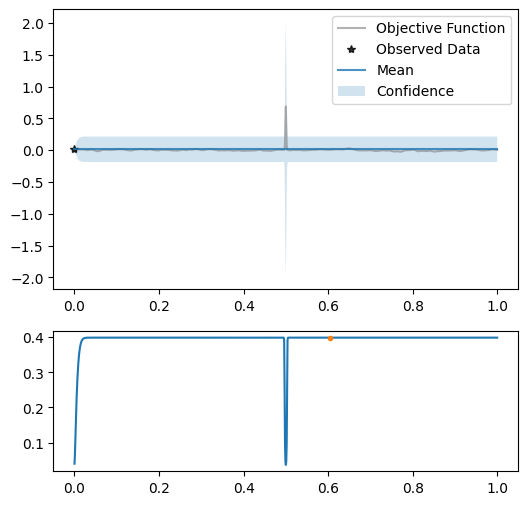

Iteration 0, measuring at x=0.6053624842315912, y=0.004350008248196293
best oberved value: 0.013677983402295115
new cost: 0.1
cumulative cost: 0.1
alpha: 1.0



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0090]), std = tensor([0.0066])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


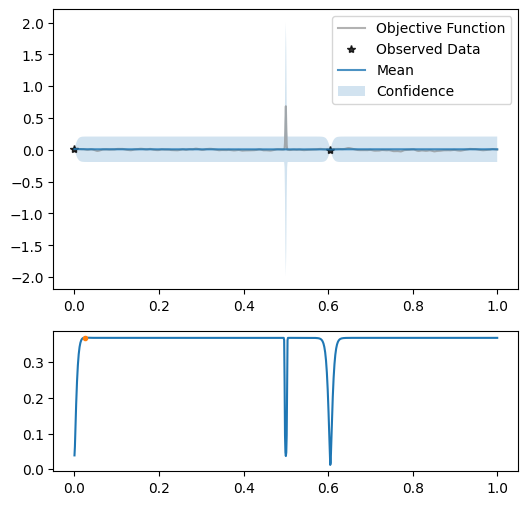

Iteration 1, measuring at x=0.0257351454600195, y=0.0060511158133591016
best oberved value: 0.013677983402295115
new cost: 0.1
cumulative cost: 0.2
alpha: 0.990909090909091



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0080]), std = tensor([0.0050])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


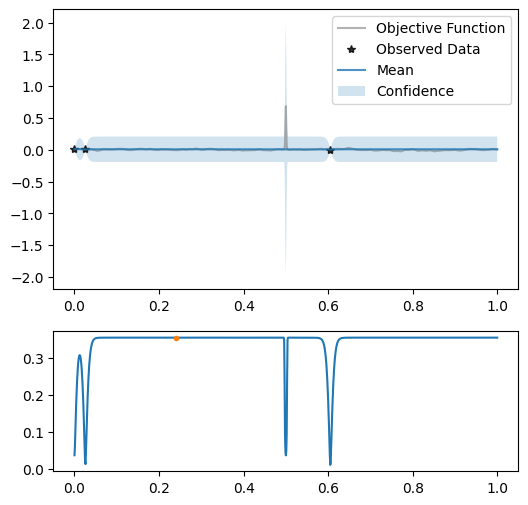

Iteration 2, measuring at x=0.23964612811859368, y=-0.006742044250923717
best oberved value: 0.013677983402295115
new cost: 0.1
cumulative cost: 0.30000000000000004
alpha: 0.9818181818181819



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0043]), std = tensor([0.0084])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 3, measuring at x=0.05871603354431063, y=-0.010863400883873846
best oberved value: 0.013677983402295115
new cost: 0.1
cumulative cost: 0.4
alpha: 0.9727272727272727

Iteration 4, measuring at x=0.577009072373896, y=0.012264164330979446
best oberved value: 0.013677983402295115
new cost: 0.1
cumulative cost: 0.5
alpha: 0.9636363636363636

Iteration 5, measuring at x=0.5553020557736299, y=0.0024049429694070756
best oberved value: 0.013677983402295115
new cost: 0.1
cumulative cost: 0.6
alpha: 0.9545454545454546



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0013]), std = tensor([0.0100])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0031]), std = tensor([0.0100])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0030]), std = tensor([0.0091])). Please consider scaling t

Iteration 6, measuring at x=0.6389441867332979, y=0.014070542807048234
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 0.7
alpha: 0.9454545454545454

Iteration 7, measuring at x=0.6602071575250695, y=0.0114270644303096
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 0.7999999999999999
alpha: 0.9363636363636364

Iteration 8, measuring at x=0.6848430953460041, y=-0.0033034875717652115
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 0.8999999999999999
alpha: 0.9272727272727272



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0044]), std = tensor([0.0093])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0052]), std = tensor([0.0090])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0043]), std = tensor([0.0089])). Please consider scaling t

Iteration 9, measuring at x=0.9215528769418597, y=-0.002448814761497336
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 0.9999999999999999
alpha: 0.9181818181818181

Iteration 10, measuring at x=0.40155910139542517, y=-0.009889101920720603
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 1.0999999999999999
alpha: 0.9090909090909091

Iteration 11, measuring at x=0.8030188163286783, y=0.006009066201208196
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 1.2
alpha: 0.9



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0037]), std = tensor([0.0087])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0026]), std = tensor([0.0092])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0028]), std = tensor([0.0088])). Please consider scaling t

Iteration 12, measuring at x=0.8308177244281507, y=-0.015024479892135336
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 1.3
alpha: 0.890909090909091

Iteration 13, measuring at x=0.7776951149703218, y=-0.009693745600183195
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 1.4000000000000001
alpha: 0.8818181818181817



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0016]), std = tensor([0.0097])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0008]), std = tensor([0.0098])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 14, measuring at x=0.5197965336311031, y=0.003971252809876594
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 1.5000000000000002
alpha: 0.8727272727272727



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0010]), std = tensor([0.0095])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 15, measuring at x=0.49150055713616214, y=0.004630821859619086
best oberved value: 0.014070542807048234
new cost: 0.10000000000000225
cumulative cost: 1.6000000000000025
alpha: 0.8636363636363636

Iteration 16, measuring at x=0.4638665968407681, y=-0.011153501450418626
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 1.7000000000000026
alpha: 0.8545454545454543



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0012]), std = tensor([0.0093])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0005]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 17, measuring at x=0.15009624249658757, y=0.010149998359315978
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 1.8000000000000027
alpha: 0.8454545454545452

Iteration 18, measuring at x=0.17185400716881918, y=0.006786766355475639
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 1.9000000000000028
alpha: 0.8363636363636361



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0010]), std = tensor([0.0094])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0013]), std = tensor([0.0093])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 19, measuring at x=0.12786929608956102, y=-0.0019407214683743535
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 2.0000000000000027
alpha: 0.827272727272727

Iteration 20, measuring at x=0.19688703475486824, y=-0.004086941459296786
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 2.1000000000000028
alpha: 0.8181818181818179



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0012]), std = tensor([0.0091])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0009]), std = tensor([0.0089])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 21, measuring at x=1.0, y=0.00421515667012155
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 2.200000000000003
alpha: 0.8090909090909087

Iteration 22, measuring at x=0.972076284791593, y=-0.0031320101669643175
best oberved value: 0.014070542807048234
new cost: 0.1
cumulative cost: 2.300000000000003
alpha: 0.7999999999999997



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0011]), std = tensor([0.0087])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0009]), std = tensor([0.0086])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 23, measuring at x=0.3195377278959942, y=0.01597153871002047
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 2.400000000000003
alpha: 0.7909090909090907

Iteration 24, measuring at x=0.3383608389611372, y=-0.002885866556623124
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 2.500000000000003
alpha: 0.7818181818181816



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0015]), std = tensor([0.0089])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0013]), std = tensor([0.0088])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 25, measuring at x=0.3010401094942017, y=-0.00038212778467442093
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 2.600000000000003
alpha: 0.7727272727272724

Iteration 26, measuring at x=0.729077555339473, y=-0.00242425110838118
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 2.7000000000000033
alpha: 0.7636363636363633



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0013]), std = tensor([0.0086])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0011]), std = tensor([0.0085])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 27, measuring at x=0.8803579537086181, y=-0.00598281329950683
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 2.8000000000000034
alpha: 0.7545454545454543

Iteration 28, measuring at x=0.0959229127192805, y=0.007538505172567801
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 2.9000000000000035
alpha: 0.745454545454545



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0009]), std = tensor([0.0085])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0011]), std = tensor([0.0084])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 29, measuring at x=0.271619772039387, y=0.009918175789538727
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 3.0000000000000036
alpha: 0.736363636363636

Iteration 30, measuring at x=0.36875477987416566, y=-0.0027790810559195594
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 3.1000000000000036
alpha: 0.727272727272727

Iteration 31, measuring at x=0.4324281296155377, y=0.0016645811351803956
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 3.2000000000000037
alpha: 0.7181818181818179

Iteration 32, measuring at x=0.9466365318356043, y=0.0120572873546283
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 3.300000000000004
alpha: 0.7090909090909088



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0014]), std = tensor([0.0084])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0013]), std = tensor([0.0083])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0013]), std = tensor([0.0082])). Please consider scaling t

Iteration 33, measuring at x=0.6232092500716586, y=0.014116916769487878
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 3.400000000000004
alpha: 0.6999999999999996

Iteration 34, measuring at x=0.7521705464861078, y=-0.016628200565360428
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 3.500000000000004
alpha: 0.6909090909090906

Iteration 35, measuring at x=0.7073389894828581, y=-0.010138271269921752
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 3.600000000000004
alpha: 0.6818181818181815

Iteration 36, measuring at x=0.8568938558700797, y=-0.017369306803939104
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 3.700000000000004
alpha: 0.6727272727272724



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0020]), std = tensor([0.0084])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0014]), std = tensor([0.0088])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0011]), std = tensor([0.0089])). Please consider scaling t

Iteration 37, measuring at x=0.21794001670389684, y=0.0050244897765924544
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 3.8000000000000043
alpha: 0.6636363636363632

Iteration 38, measuring at x=0.5372848279193415, y=-1.25341885810637e-05
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 3.9000000000000044
alpha: 0.6545454545454542

Iteration 39, measuring at x=0.9012099185061693, y=-0.002630027610305668
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 4.000000000000004
alpha: 0.6454545454545451

Iteration 40, measuring at x=0.0793263733712956, y=0.00437250690072222
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 4.100000000000004
alpha: 0.6363636363636359



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0008]), std = tensor([0.0092])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0007]), std = tensor([0.0091])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0007]), std = tensor([0.0090])). Please consider scaling t

Iteration 41, measuring at x=0.2571248745805674, y=0.008097347838523878
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 4.200000000000004
alpha: 0.6272727272727269

Iteration 42, measuring at x=0.11109047863057556, y=0.014891882028136821
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 4.300000000000003
alpha: 0.6181818181818178



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0009]), std = tensor([0.0089])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0012]), std = tensor([0.0090])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 43, measuring at x=0.5904375370989893, y=0.008908987007393213
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 4.400000000000003
alpha: 0.6090909090909088



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0014]), std = tensor([0.0090])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 44, measuring at x=0.012328469885626678, y=0.011074698978012866
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 4.500000000000003
alpha: 0.5999999999999998

Iteration 45, measuring at x=0.041025007426837644, y=0.007744678895040546
best oberved value: 0.01597153871002047
new cost: 0.1
cumulative cost: 4.600000000000002
alpha: 0.5909090909090907



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0016]), std = tensor([0.0090])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0017]), std = tensor([0.0089])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 46, measuring at x=0.2855370284131168, y=0.017340722295835838
best oberved value: 0.017340722295835838
new cost: 0.1
cumulative cost: 4.700000000000002
alpha: 0.5818181818181816

Iteration 47, measuring at x=0.5055594053785488, y=0.0010696947025823052
best oberved value: 0.017340722295835838
new cost: 0.10000211865036503
cumulative cost: 4.800002118650367
alpha: 0.5727272727272725



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0021]), std = tensor([0.0091])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0020]), std = tensor([0.0090])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 48, measuring at x=0.38461059203318515, y=-0.003273048074272668
best oberved value: 0.017340722295835838
new cost: 0.1
cumulative cost: 4.900002118650367
alpha: 0.5636361710317849



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0019]), std = tensor([0.0090])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 49, measuring at x=0.44719091123927956, y=-0.0068794231490717445
best oberved value: 0.017340722295835838
new cost: 0.1
cumulative cost: 5.000002118650366
alpha: 0.5545452619408757

Iteration 50, measuring at x=0.41785653977095405, y=-0.006896763201590007
best oberved value: 0.017340722295835838
new cost: 0.1
cumulative cost: 5.100002118650366
alpha: 0.5454543528499667



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0018]), std = tensor([0.0090])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0016]), std = tensor([0.0090])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 51, measuring at x=0.3536784442118309, y=-0.004266891204283664
best oberved value: 0.017340722295835838
new cost: 0.1
cumulative cost: 5.2000021186503655
alpha: 0.5363634437590576

Iteration 52, measuring at x=0.9865633332979287, y=0.011074112786102928
best oberved value: 0.017340722295835838
new cost: 0.1
cumulative cost: 5.300002118650365
alpha: 0.5272725346681486

Iteration 53, measuring at x=0.9350204200357759, y=0.01452500750802199
best oberved value: 0.017340722295835838
new cost: 0.1
cumulative cost: 5.400002118650365
alpha: 0.5181816255772396



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0015]), std = tensor([0.0089])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0017]), std = tensor([0.0089])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0019]), std = tensor([0.0090])). Please consider scaling t

Iteration 54, measuring at x=0.6717086419295527, y=-0.0033306934996901153
best oberved value: 0.017340722295835838
new cost: 0.1
cumulative cost: 5.5000021186503645
alpha: 0.5090907164863304

Iteration 55, measuring at x=0.6495030147647336, y=0.027613101121498704
best oberved value: 0.027613101121498704
new cost: 0.1
cumulative cost: 5.600002118650364
alpha: 0.49999980739542144

Iteration 56, measuring at x=0.8157258372636631, y=-0.016021358086065376
best oberved value: 0.027613101121498704
new cost: 0.1
cumulative cost: 5.700002118650364
alpha: 0.49090889830451234



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0018]), std = tensor([0.0089])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0023]), std = tensor([0.0095])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0019]), std = tensor([0.0097])). Please consider scaling t

Iteration 57, measuring at x=0.47851674600936933, y=0.00784253599596152
best oberved value: 0.027613101121498704
new cost: 0.1
cumulative cost: 5.800002118650363
alpha: 0.4818179892136033

Iteration 58, measuring at x=0.958620941379699, y=-0.00019466800428452285
best oberved value: 0.027613101121498704
new cost: 0.1
cumulative cost: 5.900002118650363
alpha: 0.4727270801226942

Iteration 59, measuring at x=0.791241441779926, y=0.00014964049397286374
best oberved value: 0.027613101121498704
new cost: 0.1
cumulative cost: 6.000002118650363
alpha: 0.46363617103178517

Iteration 60, measuring at x=0.18379067710414337, y=0.008088591043599946
best oberved value: 0.027613101121498704
new cost: 0.1
cumulative cost: 6.100002118650362
alpha: 0.45454526194087613



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0020]), std = tensor([0.0097])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0020]), std = tensor([0.0096])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0020]), std = tensor([0.0095])). Please consider scaling t

Iteration 61, measuring at x=0.49945100480583354, y=0.6087969136424899
best oberved value: 0.6087969136424899
new cost: 9.475172086920237
cumulative cost: 15.5751742055706
alpha: 0.44545435284996704



In [13]:
from pandora_bayesopt.acquisition import ExpectedImprovementWithCost

torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()
EIpucc_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EIpucc_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize EIpu
    alpha = (budget - cumulative_cost) / budget
    alpha = max(alpha, 0)
    EIpucc = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function, alpha=alpha)
    new_point, new_point_EIpucc = optimize_acqf(
        acq_function=EIpucc,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    if i < 3:
    
        # Plot the posterior and the EIpucc
        f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
        
        # Plot the posterior
        plot_posterior(ax1,objective_function,model,test_x,x,y)
        
        # Plot EIpucc
        acq = EIpucc.forward(test_x.unsqueeze(1).unsqueeze(1))
        ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EIpucc.numpy(),'.')
        
    plt.show()

    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EIpucc_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EIpucc_cumulative_cost_history.append(cumulative_cost)

    print("alpha:", alpha)
    print()
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Test Gittins policy with decaying lambda

Iteration: 0
new_point_EIpu: tensor(0.3989)


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0137]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


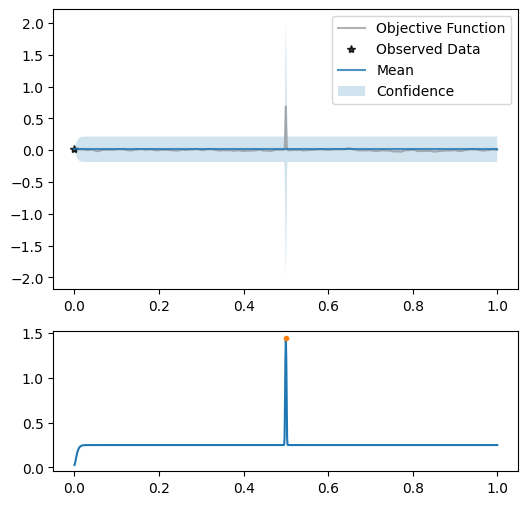

best oberved value: 0.013677983402295115
new point: [[0.50000005]]
new value: 0.6845464070241892
new acq: 1.4440419132748405
lmbda: tensor(0.0031)

new cost: 10.99999998838264
cumulative cost: 10.99999998838264
best_f: 0.6845464070241892

Iteration: 1


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3491]), std = tensor([0.4744])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


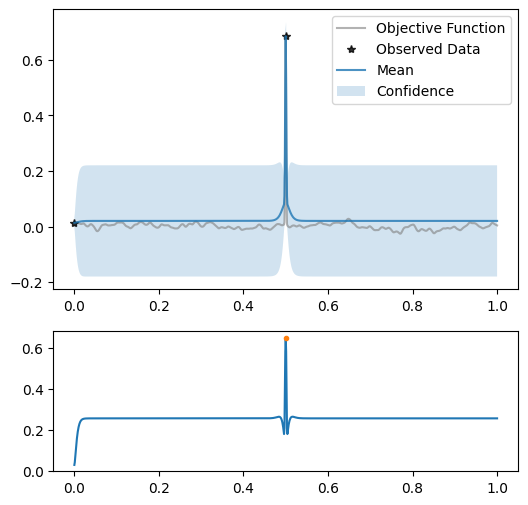

best oberved value: 0.6845464070241892
new point: [[0.5]]
new value: 0.6845484184739126
new acq: 0.6501966710439946
lmbda: tensor(0.0031)

new cost: 10.999999999992808
cumulative cost: 21.99999998837545
best_f: 0.6845484184739126



In [15]:
from pandora_bayesopt.acquisition import GittinsIndex
torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()

GIdecay_best = [best_f] # This will store the best value
cumulative_cost = 0
GIdecay_cumulative_cost_history = [0]

i = 0
while True:
    
    print("Iteration:", i)
    
    # Fit the model
    model = fit_gp_model(x, y, kernel)
    
    if i == 0 or new_point_GIdecay.item() < best_f:
        
        # Optimize EIpu
        EIpu = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function)
        new_point, new_point_EIpu = optimize_acqf(
            acq_function=EIpu,
            bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
            q=1,
            num_restarts=20,
            raw_samples=1024,
            options={'method': 'L-BFGS-B'},
        )
        print("new_point_EIpu:", new_point_EIpu)
        
    # Optimize Gittins
    GIdecay = GittinsIndex(model=model, lmbda=new_point_EIpu/128, maximize=maximize, cost=cost_function)
    new_point, new_point_GIdecay = optimize_acqf(
        acq_function=GIdecay,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    # Plot the posterior and the Gittins
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})

    # Plot the posterior
    plot_posterior(ax1, objective_function, model, test_x, x, y)

    # Plot Gittins
    GIdecay_acq = GIdecay.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), GIdecay_acq.detach().numpy(), '-', new_point.item(), new_point_GIdecay.item(), '.')
    plt.show()

    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GIdecay.item())
    print("lmbda:", new_point_EIpu/128)
    print()

    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GIdecay_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    print("best_f:", best_f)
    print()
    GIdecay_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### TODO
- Play around with different decaying lambda

## Test Gittins policy with a small constant lambda

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0137]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


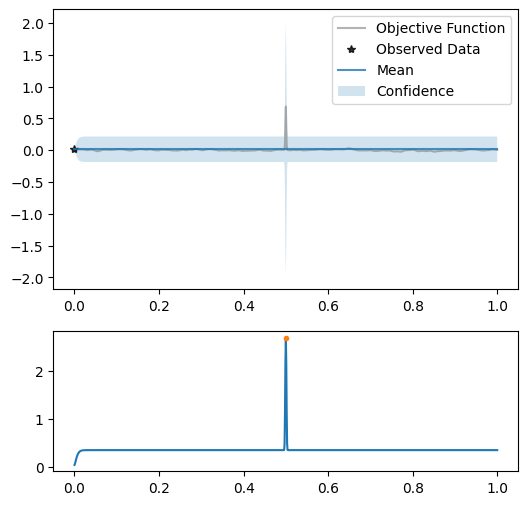

Iteration: 0
best oberved value: 0.013677983402295115
new point: [[0.5]]
new value: 0.6845485275343534
new acq: 2.7023652933813134

new cost: 10.999999999990887
cumulative cost: 10.999999999990887


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3491]), std = tensor([0.4744])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


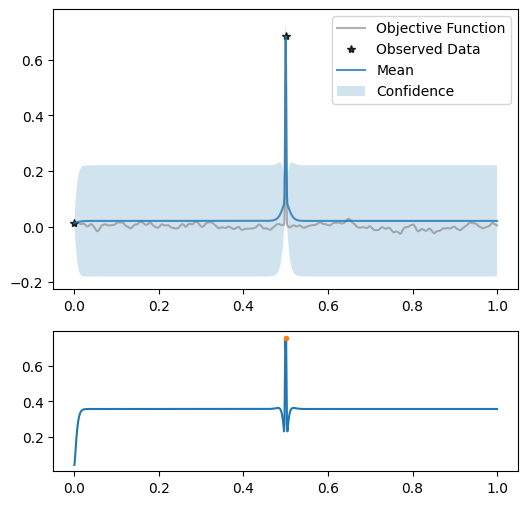

Iteration: 1
best oberved value: 0.6845485275343534
new point: [[0.5007167]]
new value: 0.5029983059948986
new acq: 0.7596932597495323

new cost: 8.531132401176766
cumulative cost: 19.531132401167653


In [16]:
from pandora_bayesopt.acquisition import GittinsIndex
x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()

GIlmbda_best = [best_f] # This will store the best value
cumulative_cost = 0
GIlmbda_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(x, y, kernel)
    
    # Optimize Gittins
    GIlmbda = GittinsIndex(model=model, lmbda=0.0001, maximize=maximize, cost=cost_function)
    new_point, new_point_GIlmbda = optimize_acqf(
        acq_function=GIlmbda,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    # Plot the posterior and the Gittins
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})

    # Plot the posterior
    plot_posterior(ax1, objective_function, model, test_x, x, y)

    # Plot Gittins
    GIlmbda_acq = GIlmbda.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), GIlmbda_acq.detach().numpy(), '-', new_point.item(), new_point_GIlmbda.item(), '.')
    plt.show()

    print("Iteration:", i)
    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GIlmbda.item())
    print()

    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GIlmbda_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    GIlmbda_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Plot best observed vs cumulative cost until the budget=1+delta

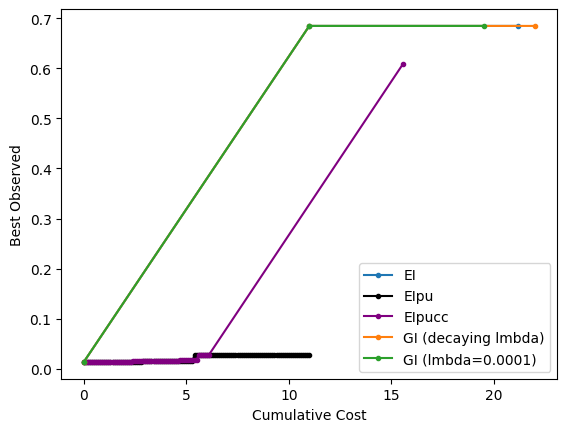

In [17]:
plt.plot(EI_cumulative_cost_history, EI_best, '.-', label="EI")
plt.plot(EIpu_cumulative_cost_history, EIpu_best, '.-', label="EIpu", color='black')
plt.plot(EIpucc_cumulative_cost_history, EIpucc_best, '.-', label="EIpucc", color='purple')
plt.plot(GIdecay_cumulative_cost_history, GIdecay_best, '.-', label="GI (decaying lmbda)")
plt.plot(GIlmbda_cumulative_cost_history, GIlmbda_best, '.-', label="GI (lmbda=0.0001)")
plt.xlabel('Cumulative Cost')
plt.ylabel('Best Observed')
plt.legend()

### Question
- Shall we caculate the average regret rather than the average best observed value across different instances?

- Shall we set a larger budget?

### TODO
- A sweep with different smoothness, lengthscales and seeds